### Desarrollado por:
- Jorge Gutiérrez Mata
- Luis Adrián Badilla Godínez

### Resumén de temas
- Transformación de Gauss con Scikit-learn.
- Transformación de Gauss con Feature-Engine.
- Discretización de igual ancho.
- Discretización de igual frecuencia.

Para el desarrollo de este cuaderno se irán cubriendo los temas mencionados anteriormente. Se divide primero en teoría seguido de un ejemplo de utilización con datasets definidos. Así mismo recordamos que **los temas aquí presentes se pueden realizar en la etapa de preprocesamiento de datos.**

Los link de descarga para los dataset son los siguientes:
1. Pokemon with stats: https://data.world/data-society/pokemon-with-stats/workspace/file?filename=Pokemon.csv
1. Red wine Quality: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/
1. Bitcoin Historical USD Price: https://www.kaggle.com/nitinsss/bitcoin-usd-stock-prices
1. Fortnite: Battle Royale - Weapon Attributes: https://www.kaggle.com/jruots/fortnite-battle-royale-weapon-attributes

### 1. Transformación de Gauss con Scikit-learn.

Scikit-learn posee transformadores (transformaciones de variables) para hacer mapeos gaussianos. El **PowerTransformer** permite hacer transformaciones Box-Cox y Yeo-Johnson y el **FunctionTransformer** nos permite especificar cualquier función que queramos.

Para el FunctionTransformer veremos ejemplos con transformaciones:
- Logarítmica
- Recíproca
- Raíz cuadrada
- Exponencial

Los tranformadores **No permiten** seleccionar columnas, pero esto se puede hacer usando un tercer transformador, el **ColumnTransformer.**

**¡Precaución!**
- Los transformadores de Scikit-learn retornan arreglos NumPy en lugar de datagrames así que se debe ser cuidadoso con el orden de las columnas.

### Importante
- Tanto Box-Cox como Yeo-Johnson necesitan aprender sus parámetros de los datos. Por lo que antes de intentar cualquier transformación es importante dividir el dataset en los conjuntos **train y test.**

- Es bueno recordar que estos algoritmos transforman variables no normales y dependientes en un figura normal permitiendo aplicar una mayor cantidad de pruebas sobre el conjunto.

## Modelo de demostración
Se verá como implementar transformaciones de variables con la biblioteca Scikit-learn y el dataset **Pokemon with stats**


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.model_selection import train_test_split

In [3]:
#Load the data
data = pd.read_csv("Pokemon_stats.csv")
data.head()


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Para poder tomar desiciones a priori se pueden encontrar los distintos tipos de variables en un dataset, buscamos las categorias y los números (ya sean variables numéricas, binarios, continuos o discretos).

In [4]:
categorical = [var for var in data.columns if data[var].dtype=='O']
print('Hay {} variables categoricas'.format(len(categorical)))

numerical = [var for var in data.columns if data[var].dtype!='O']
print('Hay {} variables numericas'.format(len(numerical)))

Hay 3 variables categoricas
Hay 10 variables numericas


Para este dataset usaremos variables numéricas positivas pues muchas de las transformaciones así lo requieren. La ventaja que posee este conjunto es que todas las columnas numéricas ya se encuentran positivas. 

Les explicamos, una manera de trabajar solo con valores positivos es aplicando logaritmo, esto se hace no para lidear con la oblicuidad o estar cerca de una distribución normal, la validez, aditividad y linearidad son más importantes.

Dado que muchos modelos tienen en su configuración este tipo de transformaciones con el fin de que la aditividad y los modelos lineales tengan más sentido así como modelos multiplicativos.

Puede leer más sobre ello en: https://statmodeling.stat.columbia.edu/2019/08/21/you-should-usually-log-transform-your-positive-data/

In [5]:
cols = []

for col in data.columns:

    if data[col].dtypes != 'O' and col != '#' and col != 'Legendary':  # if variable es numérica
        cols.append(col)  # append variable a la lista
        
        #Descomentar si hay columnas negativas
        #if np.sum(np.where(data[col] <= 0, 1, 0)) == 0:  # if variable es positiva
        #    cols.append(col)  # append variable to the list
cols

['Total',
 'HP',
 'Attack',
 'Defense',
 'Sp. Atk',
 'Sp. Def',
 'Speed',
 'Generation']

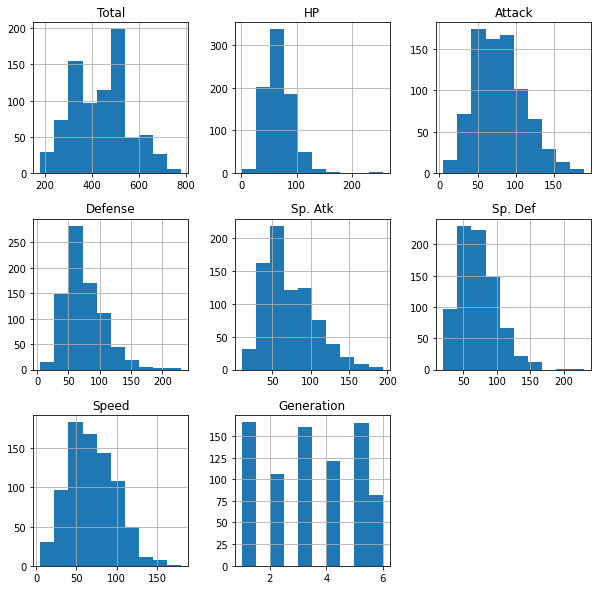

In [6]:
#Ahora podemos explorar la distribución de la variables numéricas
data[cols].hist(figsize=(10,10))
plt.show()

### Plots para evaluar normalidad

Para visualizar la distribución de las variables, debemos graficar un histograma y un gráfico Q-Q. Si la variable analizada está distribuida normalmente entonces los valores tha la variable deberían caer en una línea de 45° a la hora de graficarla contra las cantidades teóricas.

In [7]:
def diagnostic_plots(df, variable, name):
    
    #Func: Grafica los histogramas para tener una vista rápida de la distribución de la variable
    #Variables: histograma y nombre de columna del dataset que queremos analizar.
    
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title(label=name)
    plt.show()

In [15]:
#Separamos los conjuntos en entrenamiento y test
#Aquí apuntamos a decifrar el primer tipo de un pokemon a patir del resto de sus características
y_data = data["Type 1"]
df_x = df.drop(["Type 1"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    df_x, y_data, test_size=0.20, shuffle = True)

### Transformación logarítmica

In [9]:
#Se crea el transformador con la función
transformer = FunctionTransformer(np.log, validate =True)

#validate
#las entradas deben ser revisadas antes, hay 2 posibilidades.
#False, no se requiere validación.  True el arreglo input será convertido en uno bidimencional de numpy o una matriz dispersa          
#Más información en https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html


In [10]:
#Transforma todas las variables numéricas positivas
data_t = transformer.transform(X_train[cols].fillna(1))

In [11]:
# Scikit-learn retorna arreglos NumPy, así que se debe guardar en un dataframe
# Note que Scikit-learn retornará un arreglo solo con las columnas indicadas en "cols"
data_t = pd.DataFrame(data_t, columns = cols)

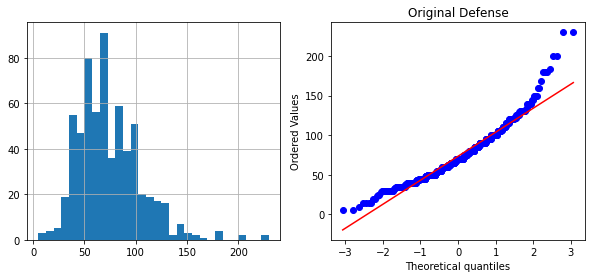

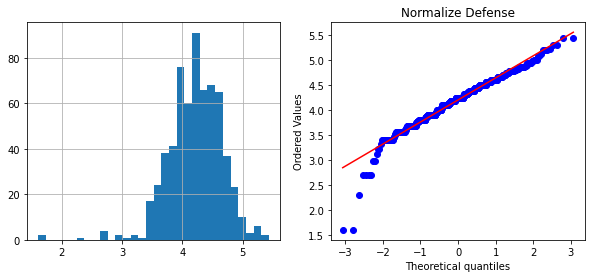

In [14]:
#A continuación se mostrarán ejemplos con "Defense" para simplicidad del cuaderno dado su largo, lo único que se debe cambiar para probar otra columna es el nombre de esta.
#['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
# Distribución original
diagnostic_plots(X_train, "Defense", "Original "+ "Defense")

# Distribución transformada
diagnostic_plots(data_t, 'Defense', "Normalize" + " Defense")

### Transformación Recíproca

In [105]:
# Se crea el transformador
transformer = FunctionTransformer(lambda x: 1/x, validate=True)

# Otra forma de hacerlo...
# transformer = FunctionTransformer(np.reciprocal, validate=True)

# Transforma las variables positivas
data_t = transformer.transform(X_train[cols].fillna(1))

# Se vuelve a almacenar en el dataframe
data_t = pd.DataFrame(data_t, columns = cols)

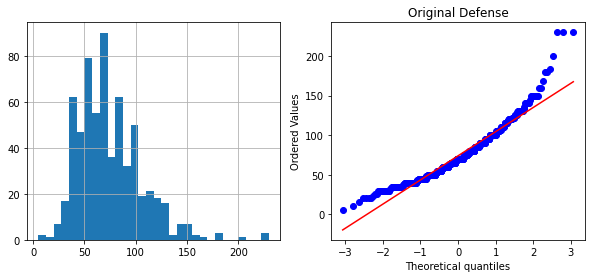

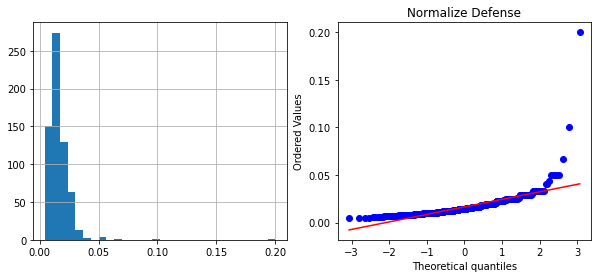

In [106]:
#A continuación se mostrarán ejemplos con "Defense"
#['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
# Distribución original
diagnostic_plots(X_train, "Defense", "Original "+ "Defense")

# Distribución transformada
diagnostic_plots(data_t, 'Defense', "Normalize " + "Defense")

### Transformación de raíz cuadrada

In [107]:
transformer = FunctionTransformer(lambda x: x**(1/2), validate=True)

# Otra forma de hacerlo
# transformer = FunctionTransformer(np.sqrt, validate=True)

data_t = transformer.transform(X_train[cols].fillna(1))

data_t = pd.DataFrame(data_t, columns = cols)

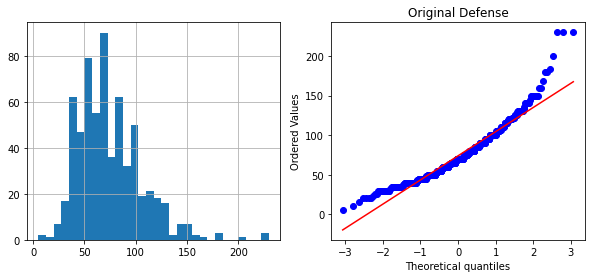

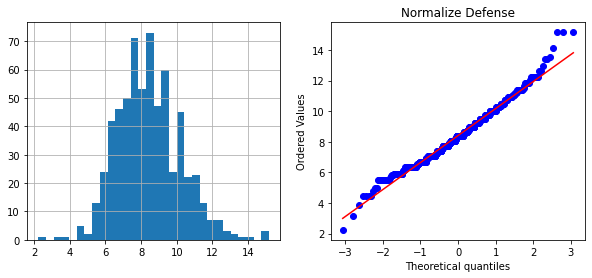

In [108]:
#['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
# Distribución original
diagnostic_plots(X_train, "Defense", "Original "+ "Defense")

# Distribución transformada
diagnostic_plots(data_t, 'Defense', "Normalize " + "Defense")

### Transformación Exponencial

In [109]:
transformer = FunctionTransformer(lambda x: x**(1/1.2), validate=True)

data_t = transformer.transform(X_train[cols].fillna(1))

data_t = pd.DataFrame(data_t, columns = cols)

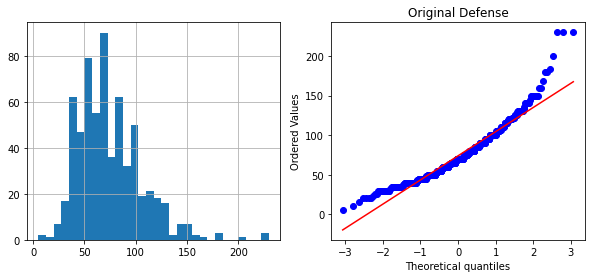

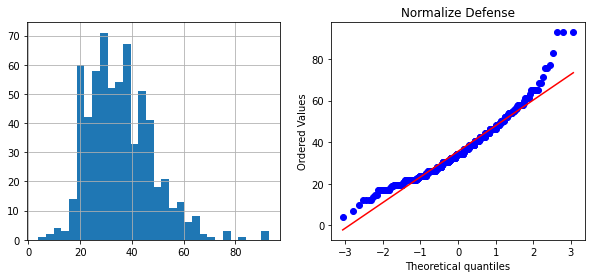

In [110]:
#['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
# Distribución original
diagnostic_plots(X_train, "Defense", "Original "+ "Defense")

# Distribución transformada
diagnostic_plots(data_t, 'Defense', "Normalize " + "Defense")

### Transformación Box-Cox

In [111]:
transformer = PowerTransformer(method='box-cox', standardize=False)

# Encuentra el lambda óptimo usando el conjunto de entrenamiento
transformer.fit(X_train[cols].fillna(1))

# Transforma los datos
data_t = transformer.transform(X_train[cols].fillna(1))

data_t = pd.DataFrame(data_t, columns = cols)

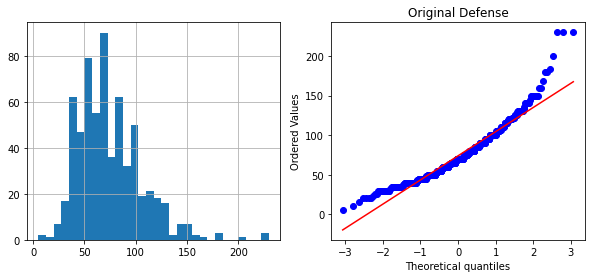

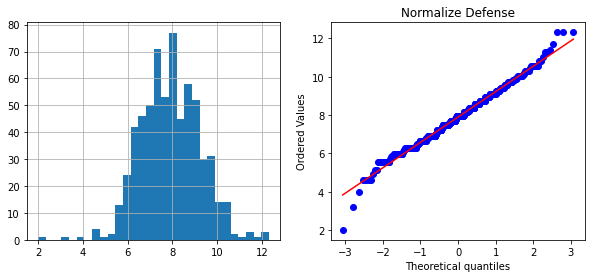

In [112]:
#['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
# Distribución original
diagnostic_plots(X_train, "Defense", "Original "+ "Defense")

# Distribución transformada
diagnostic_plots(data_t, 'Defense', "Normalize " + "Defense")

### Transformación Yeo-Johnson
Esta es una adaptación del Box-Cox que puede usar variables con valores negativos y cero por lo que en caso de tener un dataset con este tipo de valores de puede recalcular el valor cols par que lea estas columnas.

In [113]:
transformer = PowerTransformer(method='yeo-johnson', standardize=False)

# Encuentra el lambda óptimo usando el conjunto de entrenamiento
transformer.fit(X_train[cols].fillna(1))

# Transforma los datos
data_t = transformer.transform(X_train[cols].fillna(1))

data_t = pd.DataFrame(data_t, columns = cols)

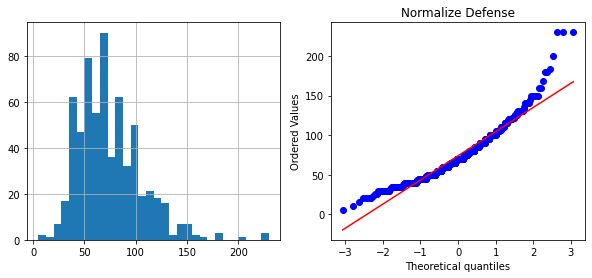

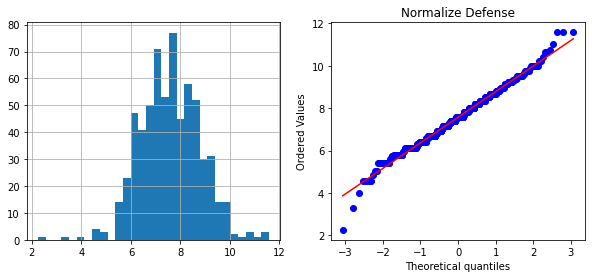

In [114]:
#['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
# Distribución original
diagnostic_plots(X_train, 'Defense', "Normalize " + "Defense")
# Distribución transformada
diagnostic_plots(data_t, 'Defense', "Normalize " + "Defense")

### 2. Transformación de Gauss con Feature-Engine.



Para esta sección, todos los conceptos, restricciones y ejemplos de muestra
vistos anteriormente volverá a ser utilizados, solo habrán dos cambios importantes:
- Primero: No usaremos la biblioteca Sklearn sino feature_engine.transformation
- Segundo: Se usará como dataset el conjunto de Red wine Quality como prueba.


In [118]:
import feature_engine.transformation as vt
#Load the data
data = pd.read_csv("winequality-red.csv")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


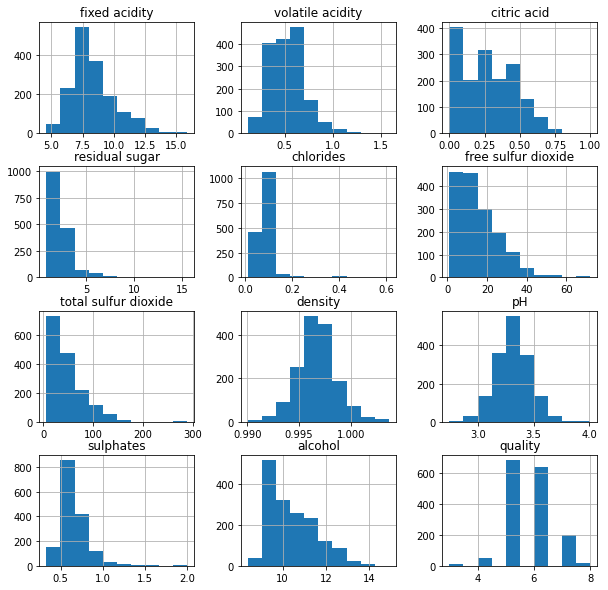

In [128]:
data.hist(figsize=(10,10))
plt.show()

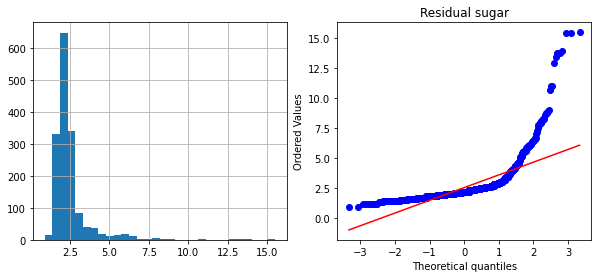

In [142]:
diagnostic_plots(data, 'residual sugar', 'Residual sugar')

### Transformación Logarítmica

['residual sugar', 'alcohol']


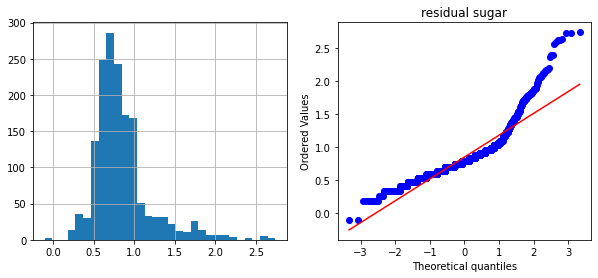

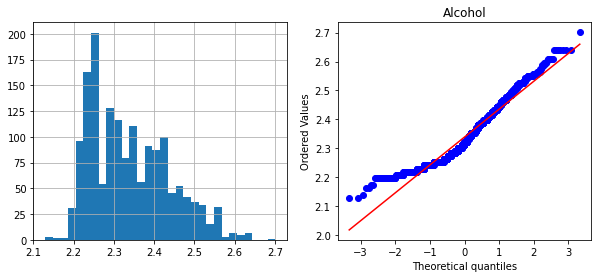

In [143]:
#De los principales cambios que tiene es que aquí podemos agregar todas las columnas
#Que queremos que sean trabajadas por el logTransformer con Feature-Engine.
lt = vt.LogTransformer(variables = ['residual sugar', 'alcohol'])
lt.fit(data)

#Variables que serán transformadas
print(lt.variables)

#Se realiza la transformación deseada
data_tf = lt.transform(data)
diagnostic_plots(data_tf, 'residual sugar', "residual sugar")
diagnostic_plots(data_tf, 'alcohol', "Alcohol")

### Transformación Recíproca

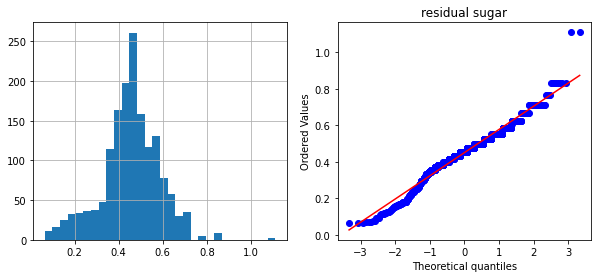

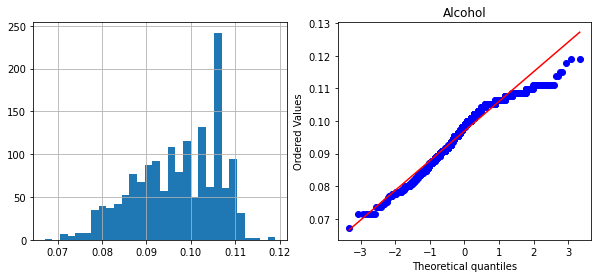

In [145]:
rt = vt.ReciprocalTransformer(variables = ['residual sugar', 'alcohol'])
rt.fit(data)
data_tf = rt.transform(data)
diagnostic_plots(data_tf, 'residual sugar', "residual sugar")
diagnostic_plots(data_tf, 'alcohol', "Alcohol")

### Transformación Exponencial

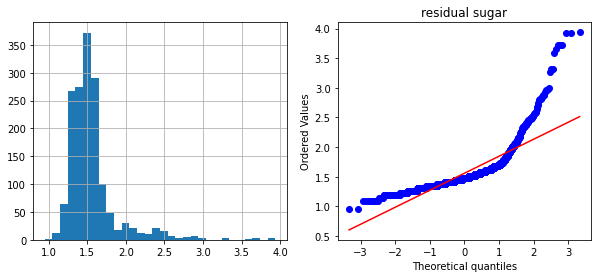

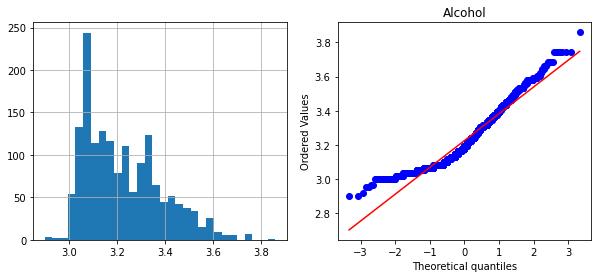

In [146]:
et = vt.PowerTransformer(variables = ['residual sugar', 'alcohol'])
et.fit(data)
data_tf = et.transform(data)
diagnostic_plots(data_tf, 'residual sugar', "residual sugar")
diagnostic_plots(data_tf, 'alcohol', "Alcohol")

### Transformación Box-Cox

{'residual sugar': -1.180347626085983, 'alcohol': -3.326061546610133}


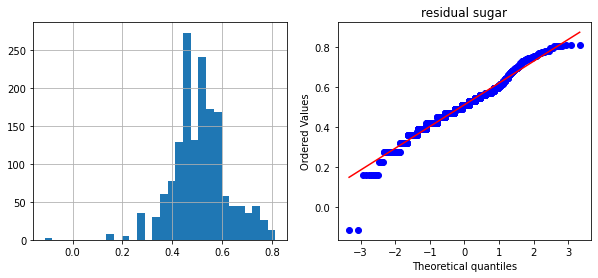

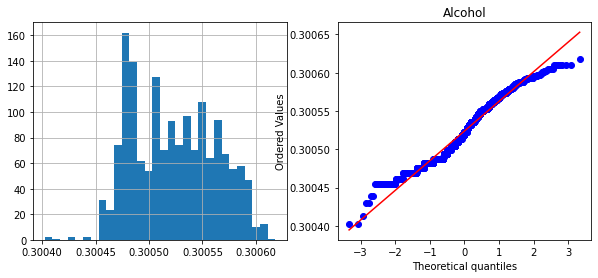

In [147]:
bct = vt.BoxCoxTransformer(variables = ['residual sugar', 'alcohol'])
bct.fit(data)
# Esto son los exponentes para la transformación BoxCox.
print(bct.lambda_dict_)
data_tf = bct.transform(data)
diagnostic_plots(data_tf, 'residual sugar', "residual sugar")
diagnostic_plots(data_tf, 'alcohol', "Alcohol")

### Transformación Yeo-Johnson

{'residual sugar': -2.039963601116243, 'alcohol': -3.71732844108761}


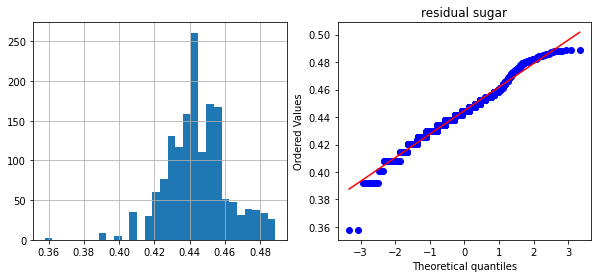

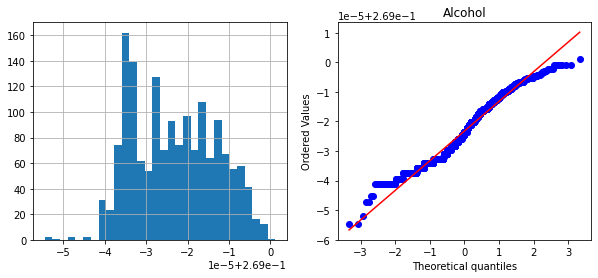

In [150]:
yjt = vt.YeoJohnsonTransformer(variables = ['residual sugar', 'alcohol'])
yjt.fit(data)
# Esto son los exponentes para la transformación Yeo-Johnson.
print(yjt.lambda_dict_)
data_tf = yjt.transform(data)
diagnostic_plots(data_tf, 'residual sugar', "residual sugar")
diagnostic_plots(data_tf, 'alcohol', "Alcohol")

## Discretización
Este es un proceso que consiste de transformar variables continuas en variables discretas por medio de la creación de intervalos continuos que abarquen el rango de valores de las variables discretas.

Este proceso ayuda a manejar datos atípicos colocando estos datos en los intervalos más bajos o altos. Por lo cual estas observaciones atípicas ya no difieren con el resto de los valores en las colas de distribución. 

Además de esto ayuda con las variables sesgadas al distribuirlas en conjuntos de intervalos con el mismo número de observaciones.

Existen varios enfoques para realizar discretización de variariables. Estos se clasifican en dos:
- Métodos no supervisados
- Métodos supervisados

Los primeros no utilizan ninguna información fuera de la distribución de las variables para crear los rangos continuos, por otro lado los segundos suelen usar información objetivo para crear estos intervalos.

En este cuaderno nos enfocaremos en dos métodos de discretización no supervisada; la discretización de igual ancho y de igual frecuencia.

## Discretización de igual ancho.
Este método lo que hace es dividir el alcance de los valores en los **N** rangos de mismo ancho que se requieran. Para calcular este ancho se calcula la diferencia entre los valores límites de los datos dividido entre el número de rangos solicitados. Es decir:
- ancho = (valor_max - valor_min)/N

Por ejemplo si los datos varían entre 25 y 450, podemos tomar un N=15, para 15 intervalos de largo:
- (450 - 25)/15 = 28.333333

Por lo cual se utilizarían intervalos de ancho 28. Es importante denotar que no existe una regla general para definir N, solamente se puede determinar experimentalmente.

### Modelo de demostración.

Se verá como implementar la discretización de igual ancho con el dataset **Bitcoin Historical USD Price**, específicamente su columnas *High* y *Low* con 
- pandas and NumPy
- Feature-engine
- Scikit-learn

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import KBinsDiscretizer

from feature_engine.discretisation import EqualWidthDiscretiser

In [2]:
# se cargan los datos, las columnas por usar serán Date, High y Low
# Date se utilizará como indice
df = pd.read_csv('bitcoin.csv', usecols=['Date','High','Low'], index_col=['Date'])
df.head(10)

,High,Low
Date,,
2017-01-01,1003.08,958.70
2017-01-02,1031.39,996.70
2017-01-03,1044.08,1021.60
2017-01-04,1159.42,1044.40
2017-01-05,1191.10,910.42
2017-01-06,1046.81,883.94
2017-01-07,908.59,823.56
2017-01-08,942.72,887.25
2017-01-09,913.69,879.81


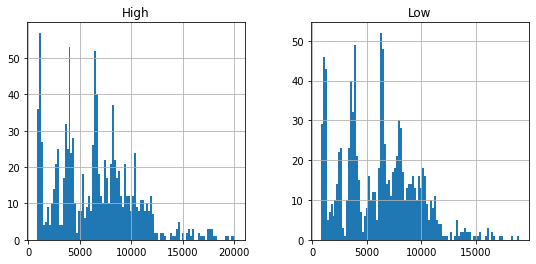

In [3]:
# este gráfico muestra la distribución de los precios más altos y más bajos
df[['High','Low']].hist(bins=100, figsize=(9,4))
plt.show()

### Ejemplo con Pandas y Numpy

In [4]:
# se obtiene el rango de la variable High
high_range = df['High'].max() - df['High'].min()

high_range

19265.69

In [5]:
# se divide este rango entre un número N de "buckets" del mismo tamaño
# en este caso al ser precios de costo del bitcoin una buena decision 
# podría ser reducir la cantidad de bins mostrados en el histograma, 
# por lo cual se toma un N = 25
high_range / 25

770.6275999999999

El rango o ancho de nuestros intervalos será de $771

In [6]:
# ahora se tomarán los extremos inferior y superior de los datos redondeados
min_value = int(np.floor(df['High'].min()))
max_value = int(np.ceil(df['High'].max()))

# ahora se redondea el tamaño de nuestro rango
inter_value = int(np.round(high_range / 25))

# se muestran estos valores
min_value, inter_value, max_value

(823, 771, 20089)

In [7]:
# se crea un arreglo con los intervalos para poder pasarlos a una función
# cut de pandas para generar los intervalos

intervals = [i for i in range(min_value, max_value + inter_value, inter_value)]

# se muestra cada uno de los valores de los intervalos
intervals

[823,
 1594,
 2365,
 3136,
 3907,
 4678,
 5449,
 6220,
 6991,
 7762,
 8533,
 9304,
 10075,
 10846,
 11617,
 12388,
 13159,
 13930,
 14701,
 15472,
 16243,
 17014,
 17785,
 18556,
 19327,
 20098]

In [8]:
# ahora creamos las etiquetas para cada uno de estos rangos

labels = ['Rango_' + str(i) for i in range(1,len(intervals))]

# se muestra cada una de las etiquetas
labels

['Rango_1',
 'Rango_2',
 'Rango_3',
 'Rango_4',
 'Rango_5',
 'Rango_6',
 'Rango_7',
 'Rango_8',
 'Rango_9',
 'Rango_10',
 'Rango_11',
 'Rango_12',
 'Rango_13',
 'Rango_14',
 'Rango_15',
 'Rango_16',
 'Rango_17',
 'Rango_18',
 'Rango_19',
 'Rango_20',
 'Rango_21',
 'Rango_22',
 'Rango_23',
 'Rango_24',
 'Rango_25']

In [9]:
# se añade una columna para las etiquetas 
df['High_disc_labels'] = pd.cut(x = df['High'],
                               bins = intervals,
                               labels = labels,
                               include_lowest = True)

# se añade una columna con los extremos del rango
df['High_disc'] = pd.cut(x = df['High'],
                        bins = intervals,
                        include_lowest = False)

df.head(10)

,High,Low,High_disc_labels,High_disc
Date,,,,
2017-01-01,1003.08,958.70,Rango_1,"(823, 1594]"
2017-01-02,1031.39,996.70,Rango_1,"(823, 1594]"
2017-01-03,1044.08,1021.60,Rango_1,"(823, 1594]"
2017-01-04,1159.42,1044.40,Rango_1,"(823, 1594]"
2017-01-05,1191.10,910.42,Rango_1,"(823, 1594]"
2017-01-06,1046.81,883.94,Rango_1,"(823, 1594]"
2017-01-07,908.59,823.56,Rango_1,"(823, 1594]"
2017-01-08,942.72,887.25,Rango_1,"(823, 1594]"
2017-01-09,913.69,879.81,Rango_1,"(823, 1594]"


Podemos ver en el resultado anterior cómo al discretizar usando el mismo ancho, colocamos cada observación de *High* dentro de un rango. Por ejemplo, el precio = 1191.10 se colocó en el Rango_1 que abarca 823-1594, mientras que el precio = 9368.48 se colocó en el Rango_12 que abarca 9304-10075.

Al realizar una discretización de igual ancho, se garantiza que los intervalos son todos de la misma longitud, pero no necesariamente habrá el mismo número de observaciones en cada uno de los intervalos. Un ejemplo de esto es el siguiente:

In [10]:
df.groupby('High_disc')['High'].count()

High_disc
(823, 1594]       124
(1594, 2365]       28
(2365, 3136]       64
(3136, 3907]       79
(3907, 4678]      114
(4678, 5449]       36
(5449, 6220]       35
(6220, 6991]      136
(6991, 7762]       61
(7762, 8533]       91
(8533, 9304]       56
(9304, 10075]      55
(10075, 10846]     52
(10846, 11617]     40
(11617, 12388]     28
(12388, 13159]      6
(13159, 13930]      3
(13930, 14701]     10
(14701, 15472]      4
(15472, 16243]      7
(16243, 17014]      4
(17014, 17785]      8
(17785, 18556]      4
(18556, 19327]      1
(19327, 20098]      3
Name: High, dtype: int64

Text(0.5, 0, 'Rangos de precio más alto')

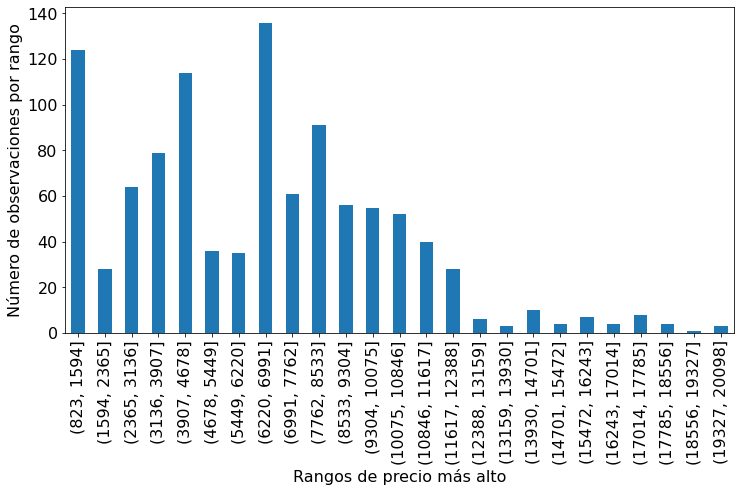

In [11]:
# se visualizan los datos discretizados
df.groupby('High_disc')['High'].count().plot.bar(figsize = (12,6), fontsize = 16)
plt.xticks(rotation = 90)
plt.ylabel('Número de observaciones por rango', fontsize = 16)
plt.xlabel('Rangos de precio más alto', fontsize = 16)

## Ejemplo con Feature-Engine

In [12]:
# con Feature-Engine se puede realizar un discretizador en una sola linea de código
discFE = EqualWidthDiscretiser(bins=25, variables = ['High'])

# se ajusta el discretizador con el df
discFE.fit(df)

# se realiza la transformación de df
df_t_FE = discFE.transform(df)

# se muestran los datos
discFE.binner_dict_

{'High': [-inf,
  1593.9375999999997,
  2364.5652,
  3135.1928,
  3905.8203999999996,
  4676.447999999999,
  5447.0756,
  6217.7032,
  6988.3308,
  7758.9583999999995,
  8529.586,
  9300.2136,
  10070.841199999999,
  10841.468799999999,
  11612.096399999999,
  12382.723999999998,
  13153.351599999998,
  13923.979199999998,
  14694.606799999998,
  15465.234399999998,
  16235.861999999997,
  17006.489599999997,
  17777.1172,
  18547.7448,
  19318.3724,
  inf]}

Se puede observar como entre cada valor hay un rango de 770.6276, es decir el valor que se encontró para los 25 intervalos

Text(0.5, 0, 'Rangos de precio más alto')

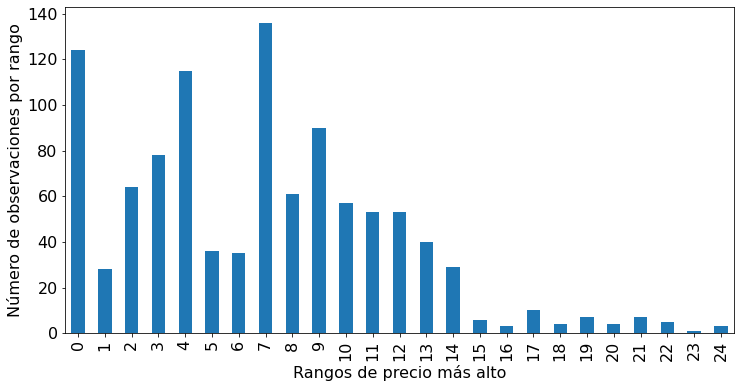

In [13]:
# se visualizan los datos discretizados
df_t_FE.groupby('High')['High'].count().plot.bar(figsize = (12,6), fontsize = 16)
plt.xticks(rotation = 90)
plt.ylabel('Número de observaciones por rango', fontsize = 16)
plt.xlabel('Rangos de precio más alto', fontsize = 16)

Para este caso se puede notar que no se encuentran identificados por su rango, sino por el número de intervalo al que pertenecen. También es importante denotar que la discretización de igual ancho no mejora la disperción de los datos, es decir en casos de variables sesgadas, las mismas seguirán sesgadas.

## Ejemplo con Scikit-learn

In [14]:
# se crea el discretizador con la funcion KBinsDiscretizer
discSKL = KBinsDiscretizer(n_bins=25, encode='ordinal', strategy='uniform')

# se ajusta el discretizador para la variable High
discSKL.fit(df[['High']])

KBinsDiscretizer(encode='ordinal', n_bins=25, strategy='uniform')

In [15]:
# se muestran los extremos de los intervalos
discSKL.bin_edges_

array([array([  823.31  ,  1593.9376,  2364.5652,  3135.1928,  3905.8204,
        4676.448 ,  5447.0756,  6217.7032,  6988.3308,  7758.9584,
        8529.586 ,  9300.2136, 10070.8412, 10841.4688, 11612.0964,
       12382.724 , 13153.3516, 13923.9792, 14694.6068, 15465.2344,
       16235.862 , 17006.4896, 17777.1172, 18547.7448, 19318.3724,
       20089.    ])], dtype=object)

In [17]:
# se discretiza la variable high asignandola a uno de los
# intervalos entre 0 y los N-1 rangos
df_t_SKL = discSKL.transform(df[['High']])

# se crea el dataframe con las columnas correspondientes
df_t_SKL = pd.DataFrame(df_t_SKL, columns = ['High'])

# se muestran los datos
df_t_SKL.head(10)

,High
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


Text(0.5, 0, 'Rangos de precio más alto')

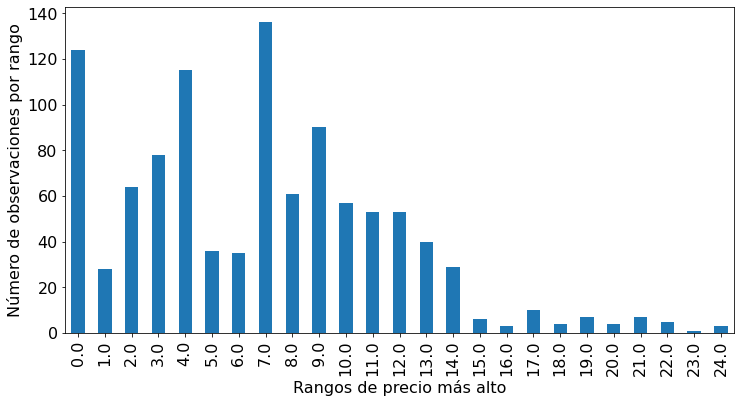

In [18]:
# se visualizan los datos discretizados
df_t_SKL.groupby('High')['High'].count().plot.bar(figsize = (12,6), fontsize = 16)
plt.xticks(rotation = 90)
plt.ylabel('Número de observaciones por rango', fontsize = 16)
plt.xlabel('Rangos de precio más alto', fontsize = 16)

## Discretización de igual frecuencia.